## TPF Fundamentos de Aprendizaje Automático

#### Alejandro Said Núñez Selin

## Objetivo:

Se tienen 6 archivos de datos obtenidos utilizando un detector Cherenkov en agua

- 1 par de una fuente de Co60 (gamma) con su respectivo fondo
- 1 par de una fuente de AmBe sin plomo (neutrones + gamma) con su respectivo fondo
- 1 par de la misma fuente AmBe con plomo (menos gammas) con su respectivo fondo

Es necesario medir un fondo aparte pues el detector no puede medir exclusiamente el espectro de la fuente, sino que los archivos donde se mide la fuente también contienen fondo.

Hasta ahora lo que se ha venido haciendo es hallar el espectro de carga de la fuente, hallar el espectro de carga del fondo y restarlos bin a bin.

#### Problema:

Con ese aproach simplemente obtendremos el espectro de carga de la fuente (o de alturas) pero no obtendremos los pulsos reales de la fuente pues están mezclados con el fondo.

Por tanto se plantean como objetivo (no digo que se vaya a cumplir a corto plazo):

-   Intentar sacar los pulsos que pertenecen solamente al tipo de radiación de la fuente de los archivos de medicion con fuente (estoy haciendo trampa acá, lo ideal sería diferenciar un gamma de la fuente de un gamma del fondo, pero no sé si eso es siquiera posible)
-   (Más a futuro) medir con una mayor cantidad de fuentes de diferentes tipos de radiación para caracterizar bien cada tipo de pulsos y poder del fondo natural decir cuáles pulsos pertenecen a cuál tipo de radiación
-   Por ahora me conformo con poder clasificar los pulsos gammas y de neutrones del resto del fondo de partículas (me vine arriba acá)

#### Disclaimer:

-   Los neutrones son partículas inestables fuera del núcleo atómico, por tanto se espera que hallan muy pocos neutrones en el fondo y por tanto sean más fáciles de clasificar

-   Los gammas en cambio son estables, y no solamente eso, sino que pueden ser producto de casi cualquier proceso atómico o nuclear, por lo que pueden venir de diferentes fuentes. Se intentarán clasificar pensando en que los gammas emitidos por la fuente son diferentes del resto de gammas del fondo (es el éxtasis cuando empiezas un nuevo proyecto, no me hagan caso)

Artículo sobre un tema parecido: https://www.researchgate.net/publication/381404338_Comprehensive_Machine_Learning_Model_Comparison_
for_Cherenkov_and_Scintillation_Light_Separation_due_to_Particle_Interactions

## Vamos a ver qué encontramos y cómo lo intentamos solucionar en el camino!!

Intentemos primeramente cargar los datos y ver qué forma tienen los pulsos

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import re
import os
import csv

Algunas funciones para reutilizar código

In [21]:
def sub_arr(arr):
    """
    Retorna una sub-array de 'arr' que contiene todos los elementos no negativos (pulso) 
    que se extienden hacia afuera desde el índice 8 hasta que se encuentran elementos negativos en ambos extremos.
    
    Parámetros:
    arr (list): Una lista de números enteros (evento).
    
    Retorna:
    list: Una sub-array de 'arr' con números enteros no negativos (pulso).
    """
    start, end = 8, 8
    while start >= 0 and arr[start] > 0:
        start -= 1
    while end < len(arr) and arr[end] > 0:
        end += 1
    if start == -1 and end == len(arr):
        return []
    if arr[start] < 0:
        start += 1
    if arr[end - 1] < 0:
        end -= 1
    return arr[start:end]

In [22]:
def subsegments(new_data):
    """
    Genera subsegmentos de datos a partir de segmentos proporcionados.

    Parámetros:
    new_data (list): Una lista de listas de números enteros (segmentos de datos).

    Retorna:
    list: Una lista de subsegmentos de datos.
    """
    return [sub_arr(segment) for segment in new_data if len(sub_arr(segment)) > 0]

In [23]:
def load_data(file_list):
    """
    Carga datos de una lista de archivos, calcula los máximos, las sumas y los pulsos promedio.

    Parámetros:
    file_list (list): Una lista de rutas de archivos a cargar.

    Retorna:
    tuple: Tres listas, una con los máximos, otra con las sumas y otra con los pulsos promedio para cada archivo.
    """
    all_max_per_file, all_sum_per_file, mean_pulses = [], [], []
    for file in file_list:
        data = np.loadtxt(file, np.int32, usecols=0)
        print(f'Longitud de {file}: {len(data)}')
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)
        mean_pulses.append(np.mean(new_data, axis=0))
        subsegment_data = subsegments(new_data)
        if subsegment_data:
            max_values = [np.max(subsegment) for subsegment in subsegment_data]
            all_max_per_file.append(max_values)
            sum_values = [np.sum(subsegment) for subsegment in subsegment_data]
            all_sum_per_file.append(sum_values)
    return all_max_per_file, all_sum_per_file, mean_pulses

In [24]:
def plot_histogram(data, bin_width, labels, title, x_label, y_label, log_scale=False, xlim=None):
    """
    Genera y muestra un histograma a partir de los datos proporcionados.

    Parámetros:
    data (list): Lista de listas con los datos a graficar.
    bin_width (int): Ancho del bin para el histograma.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    log_scale (bool): Si True, el eje y estará en escala logarítmica.
    xlim (tuple): Limites en el eje x.
    """
    for d, label in zip(data, labels):
        plt.hist(
            d,
            bins=np.arange(np.min(d), np.max(d), bin_width),
            histtype='step',
            label=label,
            linewidth=1.5
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(xlim)
    plt.grid(True)
    plt.show()

In [25]:
def plot_mean_pulses(mean_pulses, labels, title, x_label, y_label):
    """
    Genera y muestra un gráfico de los pulsos promedio.

    Parámetros:
    mean_pulses (list): Lista de listas con los pulsos promedio.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    """
    for pulse, label in zip(mean_pulses, labels):
        plt.plot(pulse, linewidth=1.5, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

In [26]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filtra y guarda los datos que se encuentran dentro del rango de carga especificado.

    Parámetros:
    file_list (list): Lista de archivos a procesar.
    charge_range (tuple): Rango de carga (min, max) para filtrar los datos.
    output_dir (str): Directorio donde se guardarán los archivos filtrados.
    """
    fuente_data, fondo_data = [], []
    fuente_file, fondo_file = file_list
    for file, data_list in zip([fuente_file, fondo_file], [fuente_data, fondo_data]):
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        segments = data[:num_segments * 32].reshape(-1, 32)
        subsegment_data = subsegments(segments)
        if subsegment_data:
            for index, subsegment in enumerate(subsegment_data):
                if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                    data_list.append(segments[index])
    os.makedirs(output_dir, exist_ok=True)
    if fuente_data:
        np.savetxt(os.path.join(output_dir, "fuente_pulsos.csv"), np.array(fuente_data), delimiter=',', fmt='%d')
    if fondo_data:
        np.savetxt(os.path.join(output_dir, "fondo_pulsos.csv"), np.array(fondo_data), delimiter=',', fmt='%d')
    print(f"Datos guardados en {output_dir}")

Reemplazar en caso que la dirección de los archivos sea otra. Estos archivos no se van a subir directamente al repositorio porque son muy pesados, no son necesarios para el análisis de los modelos utilizados, pero si igualmente quieres obtenerlos sigue los pasos del README

In [27]:
file_list_Co = sorted(glob.glob('data/*Co*'))
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))
file_list_AmBe_noplomo = sorted(glob.glob('data/*10cm_noplomo*'))

Cálculo de las alturas, la carga y el pulso promedio, empecemos con el Co60

In [28]:
all_max_per_file_Co, all_sum_per_file_Co, mean_pulses_Co = load_data(file_list_Co)

Longitud de data/Co_1200V_170t1_5min.dat: 95742672
Longitud de data/fondo_Co_1200V_170t1_5min.dat: 59981350


Vamos a ver los histogramas de carga y los pulsos medios respectivamente de los espectros

Veamos todo el rango energético primero

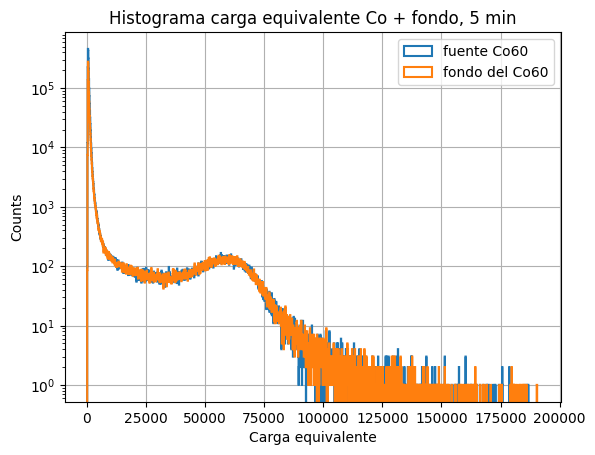

In [29]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=100, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

La parte donde actúa la fuente parece ser la de baja energía

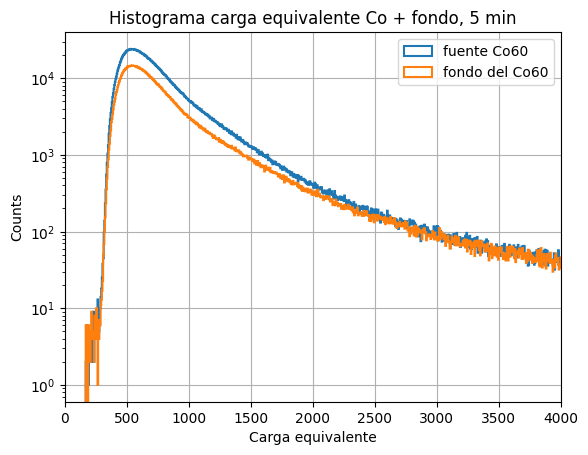

In [30]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=5, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(0, 4000)
)

Veamos ahora los pulsos medios

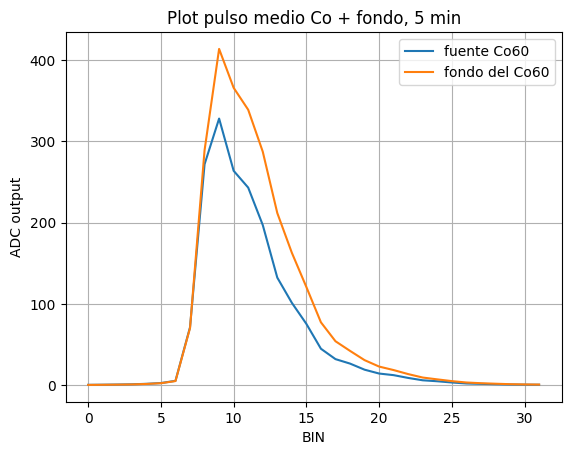

In [31]:
plot_mean_pulses(
    mean_pulses_Co, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Plot pulso medio Co + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy similares, la forma de la señal parece ser mas menos la misma, pero los pulsos del fondo parecen más altos, lo más probable es que sea porque hay una mayor cantidad de cuentas en la parte de baja energía para la medición con fuente, eso afecta la estadística a la hora de hacer un promedio.

Anyways guardemos una parte del espectro del fondo y la fuente, de 500 a 600 en carga parece bien, hay bastante población de la fuente en ese rango energético

In [32]:
charge_thresholds_Co = (500, 600)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_Co, charge_thresholds_Co, "Co60")

Datos guardados en Co60


Libreremos memoria con lo que ya no se va a utilizar

In [33]:
del all_max_per_file_Co
del all_sum_per_file_Co

Vamos a por AmBe ahora (neutrones + gamma), empecemos con el que tiene plomo

In [34]:
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))
all_max_per_file_AmBe_plomo, all_sum_per_file_AmBe_plomo, mean_pulses_AmBe_plomo = load_data(file_list_AmBe_plomo)

Longitud de data/AmBe_30cm_10cm_plomo_1200V_650t1_5min.dat: 96712340
Longitud de data/fondo_10cm_plomo_1200V_170t1_5min.dat: 63388416


Nuevamente veamos todo el rango energético

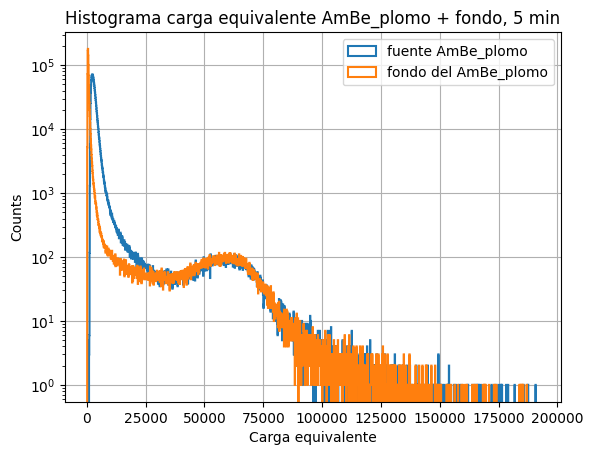

In [35]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=100, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

Hagamos zoom donde actúa la fuente

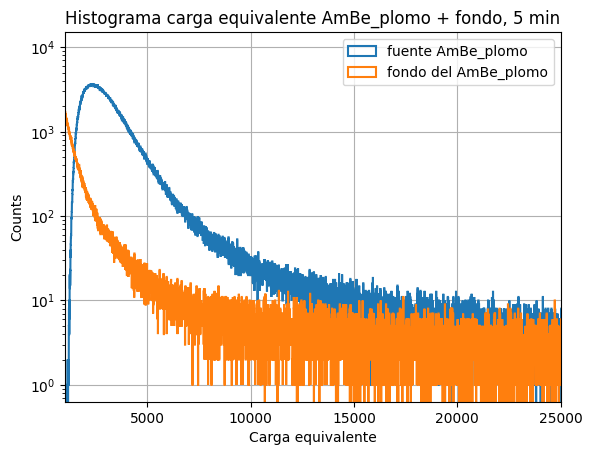

In [36]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=5, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

Y el pulso medio

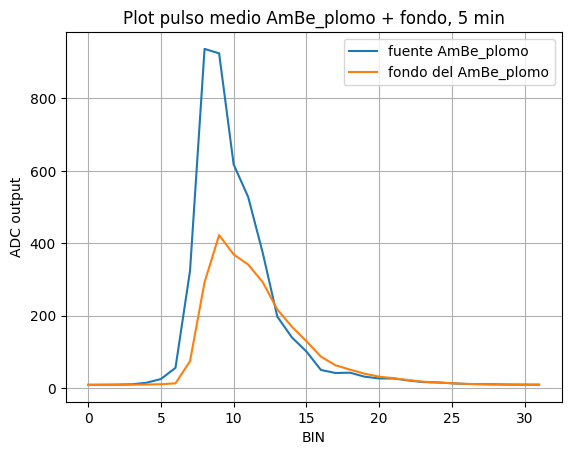

In [37]:
plot_mean_pulses(
    mean_pulses_AmBe_plomo, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Plot pulso medio AmBe_plomo + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy diferentes en este caso, deben ser más clasificables los neutrones

Nuevamente guardemos un pedazo del espectro, de 4000 - 6000 parece bien

In [38]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_plomo, charge_thresholds_AmBe, "AmBe_plomo")

Datos guardados en AmBe_plomo


In [39]:
del all_max_per_file_AmBe_plomo
del all_sum_per_file_AmBe_plomo

Veamos ahora la misma fuente, pero sin plomo. Al no estar presente el plomo, los gammas no son escudados y por ende hay mayor cantidad de carga total

In [40]:
all_max_per_file_AmBe_noplomo, all_sum_per_file_AmBe_noplomo, mean_pulses_AmBe_noplomo = load_data(file_list_AmBe_noplomo)

Longitud de data/AmBe_30cm_10cm_noplomo_1200V_650t1_5min.dat: 102023726
Longitud de data/fondo_10cm_noplomo_1200V_170t1_5min.dat: 63388416


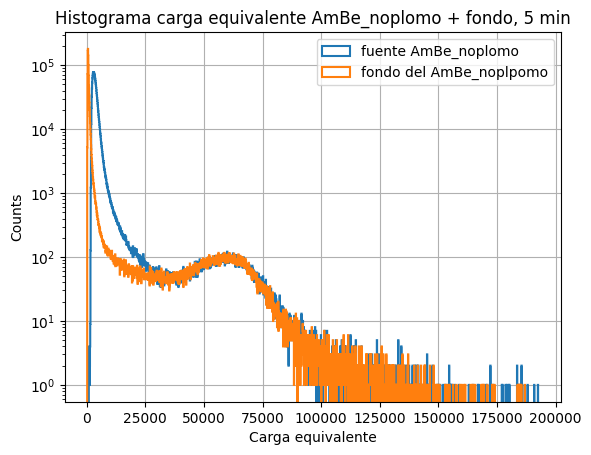

In [41]:
plot_histogram(
    all_sum_per_file_AmBe_noplomo, 
    bin_width=100, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplpomo'], 
    title='Histograma carga equivalente AmBe_noplomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

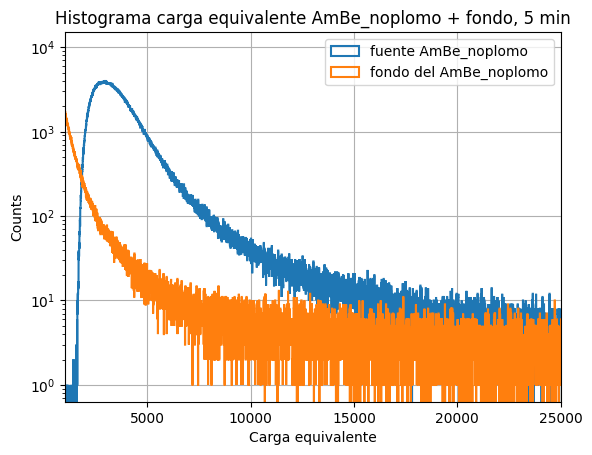

In [42]:
plot_histogram(
    all_sum_per_file_AmBe_noplomo, 
    bin_width=5, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplomo'], 
    title='Histograma carga equivalente AmBe_noplomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

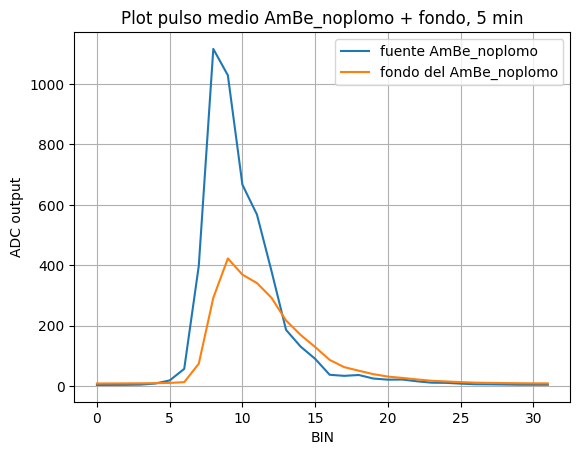

In [43]:
plot_mean_pulses(
    mean_pulses_AmBe_noplomo, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplomo'], 
    title='Plot pulso medio AmBe_noplomo + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Igualmente estos pulsos parecen muy diferentes de los pulsos del fondo. Veamos una comparación entre los 4 tipos de pulsos

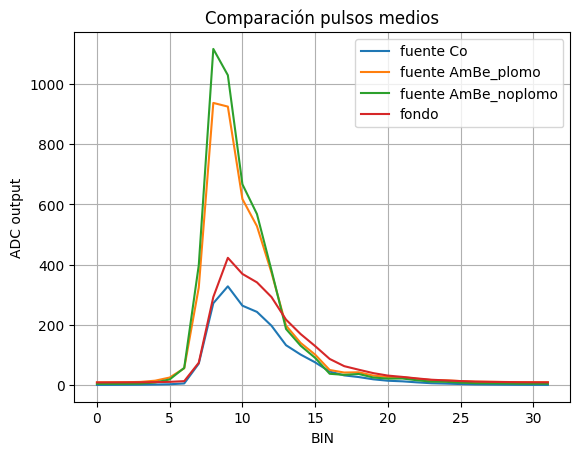

In [44]:
plt.plot(mean_pulses_Co[0], label = 'fuente Co')
plt.plot(mean_pulses_AmBe_plomo[0], label = 'fuente AmBe_plomo')
plt.plot(mean_pulses_AmBe_noplomo[0], label = 'fuente AmBe_noplomo')
plt.plot(mean_pulses_AmBe_noplomo[1], label = 'fondo')
plt.title('Comparación pulsos medios')
plt.xlabel('BIN')
plt.legend()
plt.grid()
plt.ylabel('ADC output')
plt.show()

Ciertamente parece que se puede hacer algo, los pulsos de AmBe son muy diferentes al resto, no solamente en carga sino tambien en forma, aunque los pulsos del Co60 son muy parecidos al fondo en cuanto a forma

In [45]:
charge_thresholds_AmBe_noplomo = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_noplomo, charge_thresholds_AmBe_noplomo, "AmBe_noplomo")

Datos guardados en AmBe_noplomo


In [46]:
del all_max_per_file_AmBe_noplomo
del all_sum_per_file_AmBe_noplomo

In [47]:
del mean_pulses_AmBe_noplomo
del mean_pulses_AmBe_plomo
del mean_pulses_Co

Estuve pensando cuántas dimensiones usar en el clasificador, primeramente pensé en 5, siendo estas, carga del pulso, altura, tiempo de subida (posición donde se alcanza el máximo), tiempo de bajada y ancho, pero luego caí en cuenta que como todos los pulsos tienen un ancho de 32 valores,
#### Podemos usar las 32 dimensiones!!
total una imagen de baja calidad es más que eso

Empecemos usando RandomForest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

Función para cargar datos y etiquetas

In [2]:
def cargar_datos_y_etiquetas(fuente_file, fondo_file):
    """
    Carga los datos y etiquetas desde los archivos fuente y fondo,
    y devuelve los datos combinados y las etiquetas correspondientes.

    Args:
        fuente_file (str): Ruta del archivo de datos fuente.
        fondo_file (str): Ruta del archivo de datos fondo.

    Returns:
        tuple: Un tuple que contiene los datos combinados y las etiquetas correspondientes.
            - data (ndarray): Un array numpy que contiene los datos combinados.
            - labels (ndarray): Un array numpy que contiene las etiquetas correspondientes.
    """

    fuente_pulsos = np.loadtxt(fuente_file, delimiter=',')
    fondo_pulsos = np.loadtxt(fondo_file, delimiter=',')
    
    #Crear un array de etiquetas 1 con la misma cantidad de filas que fuente_pulsos
    fuente_labels = np.ones(fuente_pulsos.shape[0])
    #Crear un array de etiquetas 0 con la misma cantidad de filas que fondo_pulsos.
    fondo_labels = np.zeros(fondo_pulsos.shape[0])

    #Combinar los datos 
    data = np.vstack((fuente_pulsos, fondo_pulsos))
    #Concatenar las etiquetas
    labels = np.concatenate((fuente_labels, fondo_labels))
    return data, labels

In [3]:
def train_and_evaluate_classifier(data, labels):
    """
    Trains a random forest classifier on the given data and labels, and evaluates its performance.

    Parameters:
    data (array-like): The input data for training and evaluation.
    labels (array-like): The corresponding labels for the input data.

    Returns:
    clf (RandomForestClassifier): The trained random forest classifier.

    """

    #Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

    #Crear una instancia de SMOTE para balancear las clases y que el modelo no se incline sobre la clase mayoritaria
    sm = SMOTE(random_state=42)
    #Aplicar SMOTE en el conjunto de entrenamiento
    X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

    # Se crea un clasificador Random Forest con 100 árboles de decisión y una semilla aleatoria de 42 
    # para asegurar que los resultados sean reproducibles. Este enfoque se utiliza debido a la 
    # eficacia del Random Forest en tareas de clasificación, su robustez y capacidad para manejar 
    # datos desbalanceados cuando se combina con técnicas como SMOTE.
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Entrenamos el clasificador con los datos balanceados
    clf.fit(X_train_balanced, y_train_balanced)
    # Realizar predicciones sobre el conjunto de prueba
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return clf

In [4]:
def plot_pulse_average(pulso_medio, title):
    """
    Plots the average pulse.

    Parameters:
    pulso_medio (array-like): The average pulse data.
    title (str): The title of the plot.

    Returns:
    None
    """
    plt.plot(pulso_medio)
    plt.title(title)
    plt.xlabel('BIN')
    plt.ylabel('ADC output')
    plt.grid(True)
    plt.show()

Cargar datos para AmBe_plomo 

In [5]:
fuente_file_AmBe_plomo = 'AmBe_plomo/fuente_pulsos.csv'
fondo_file_AmBe_plomo = 'AmBe_plomo/fondo_pulsos.csv'

In [6]:
data_AmBe_plomo, labels_AmBe_plomo = cargar_datos_y_etiquetas(fuente_file_AmBe_plomo, fondo_file_AmBe_plomo)

In [7]:
clf_AmBe_plomo = train_and_evaluate_classifier(data_AmBe_plomo, labels_AmBe_plomo)

Accuracy: 0.9973056900173531
Confusion Matrix:
 [[ 2076    70]
 [  107 63441]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2146
         1.0       1.00      1.00      1.00     63548

    accuracy                           1.00     65694
   macro avg       0.97      0.98      0.98     65694
weighted avg       1.00      1.00      1.00     65694



La precisión del modelo es 0.9973, lo que indica que el modelo clasifica correctamente el 99.73% de los datos de prueba

Parece bien! Vamos a intentar clasificar neutrones del fondo

In [8]:
fuente_real_AmBe_plomo = np.loadtxt(fuente_file_AmBe_plomo, delimiter=',')
predictions_fuente_AmBe_plomo = clf_AmBe_plomo.predict(fuente_real_AmBe_plomo)
fuente_predicha_AmBe_plomo = fuente_real_AmBe_plomo[predictions_fuente_AmBe_plomo == 1]
fondo_predicho_AmBe_plomo = fuente_real_AmBe_plomo[predictions_fuente_AmBe_plomo == 0]

Veamos que sucede con la fuente de Co60, esto es una fuente gamma con 2 picos energéticos, uno en 1.17MeV y el otro 1.33MeV, el problema es que nuestro detector no es un espectrómetro, no se van a poder observar 2 picos, sino todo un continuo, siendo el último bin donde corta con el fondo el equivalente a esos 1.33MeV (cosas de ángulos de Compton)

El resumen es que probablemente no halla algo así como "gammas de forma característica"

Anyways hagamos el mismo procedimiento y veamos qué obtenemos

In [9]:
fuente_file_Co60 = 'Co60/fuente_pulsos.csv'
fondo_file_Co60 = 'Co60/fondo_pulsos.csv'

In [10]:
data_Co60, labels_Co60 = cargar_datos_y_etiquetas(fuente_file_Co60, fondo_file_Co60)

In [11]:
clf_Co60 = train_and_evaluate_classifier(data_Co60, labels_Co60)

Accuracy: 0.6049145709349203
Confusion Matrix:
 [[  9729  75226]
 [ 13268 125764]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.11      0.18     84955
         1.0       0.63      0.90      0.74    139032

    accuracy                           0.60    223987
   macro avg       0.52      0.51      0.46    223987
weighted avg       0.55      0.60      0.53    223987



#### :(

In [12]:
# Pulsos originales de fuente + fondo en fuente_pulsos.csv
fuente_real_Co60 = np.loadtxt(fuente_file_Co60, delimiter=',')

# Pasandole el clasificador entrenado
predictions_fuente_Co60 = clf_Co60.predict(fuente_real_Co60)

# Separar los pulsos predichos como fuente y como fondo de los pulsos originales de fuente_pulsos.csv
fuente_predicha_Co60 = fuente_real_Co60[predictions_fuente_Co60 == 1]
fondo_predicho_Co60 = fuente_real_Co60[predictions_fuente_Co60 == 0]

Intenemos cargar los datos de AmBe sin plomo ahora

In [13]:
fuente_file_AmBe_noplomo = 'AmBe_noplomo/fuente_pulsos.csv'
fondo_file_AmBe_noplomo = 'AmBe_noplomo/fondo_pulsos.csv'

In [14]:
data_AmBe_noplomo, labels_AmBe_noplomo = cargar_datos_y_etiquetas(fuente_file_AmBe_noplomo, fondo_file_AmBe_noplomo)

In [15]:
clf_AmBe_noplomo = train_and_evaluate_classifier(data_AmBe_noplomo, labels_AmBe_noplomo)

Accuracy: 0.999003427238035
Confusion Matrix:
 [[  2117     61]
 [    62 121183]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2178
         1.0       1.00      1.00      1.00    121245

    accuracy                           1.00    123423
   macro avg       0.99      0.99      0.99    123423
weighted avg       1.00      1.00      1.00    123423



Igualmente parece muy diferente del fondo natural

In [16]:
# Pulsos originales de fuente + fondo en fuente_pulsos.csv
fuente_real_AmBe_noplomo = np.loadtxt(fuente_file_AmBe_noplomo, delimiter=',')

# Pasandole el clasificador entrenado
predictions_fuente_AmBe_noplomo = clf_AmBe_noplomo.predict(fuente_real_AmBe_noplomo)

# Separar los pulsos predichos como fuente y como fondo de los pulsos originales de fuente_pulsos.csv
fuente_predicha_AmBe_noplomo = fuente_real_AmBe_noplomo[predictions_fuente_AmBe_noplomo == 1]
fondo_predicho_AmBe_noplomo = fuente_real_AmBe_noplomo[predictions_fuente_AmBe_noplomo == 0]

#### Qué tenemos hasta ahora? 

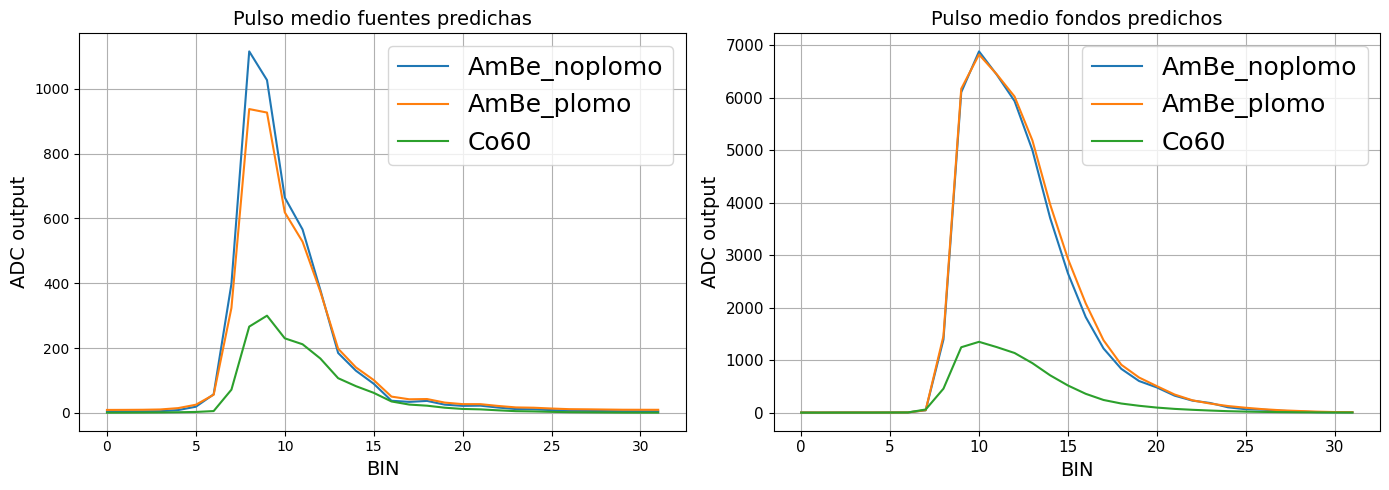

In [19]:
pulso_medio_fuente_predicha_AmBe_noplomo = np.mean(fuente_predicha_AmBe_noplomo, axis=0)
pulso_medio_fuente_predicha_AmBe_plomo = np.mean(fuente_predicha_AmBe_plomo, axis=0)
pulso_medio_fuente_predicha_Co60 = np.mean(fuente_predicha_Co60, axis=0)

pulso_medio_fondo_predicho_AmBe_noplomo = np.mean(fondo_predicho_AmBe_noplomo, axis=0)
pulso_medio_fondo_predicho_AmBe_plomo = np.mean(fondo_predicho_AmBe_plomo, axis=0)
pulso_medio_fondo_predicho_Co60 = np.mean(fondo_predicho_Co60, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

axs[0].plot(pulso_medio_fuente_predicha_AmBe_noplomo, label='AmBe_noplomo')
axs[0].plot(pulso_medio_fuente_predicha_AmBe_plomo, label='AmBe_plomo')
axs[0].plot(pulso_medio_fuente_predicha_Co60, label='Co60')
axs[0].set_title('Pulso medio fuentes predichas', fontsize=14)
axs[0].set_xlabel('BIN', fontsize=14)
axs[0].set_ylabel('ADC output', fontsize=14)
axs[0].grid(True)
axs[0].legend(fontsize=18)

axs[1].plot(pulso_medio_fondo_predicho_AmBe_noplomo, label='AmBe_noplomo')
axs[1].plot(pulso_medio_fondo_predicho_AmBe_plomo, label='AmBe_plomo')
axs[1].plot(pulso_medio_fondo_predicho_Co60, label='Co60')
axs[1].set_title('Pulso medio fondos predichos', fontsize=14)
axs[1].set_xlabel('BIN', fontsize=14)
axs[1].set_ylabel('ADC output', fontsize=14)
axs[1].grid(True)
axs[1].legend(fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

Los fondos sacados ciertamente lucen parecidos en cuanto a forma, el fondo sacado del Co60 tiene menor carga pero es porq los pulsos son de una zona de más baja energía

Veamos la carga de las fuentes en cada caso

In [21]:
print(f"Carga fuente real AmBe_noplomo + fondo {fuente_real_AmBe_noplomo.sum()}")
print(f"Carga fuente real AmBe_plomo + fondo {fuente_real_AmBe_plomo.sum()}")
print(f"Razon real {fuente_real_AmBe_noplomo.sum() / fuente_real_AmBe_plomo.sum()}")

Carga fuente real AmBe_noplomo + fondo 1988655138.0
Carga fuente real AmBe_plomo + fondo 985038694.0
Razon real 2.018859919019587


In [22]:
print(f"Carga fuente predicha AmBe_noplomo {fuente_predicha_AmBe_noplomo.sum()}")
print(f"Carga fuente predicha AmBe_plomo {fuente_predicha_AmBe_plomo.sum()}")
print(f"Razon predicha {fuente_predicha_AmBe_noplomo.sum() / fuente_predicha_AmBe_plomo.sum()}")

Carga fuente predicha AmBe_noplomo 1985916264.0
Carga fuente predicha AmBe_plomo 980142111.0
Razon predicha 2.026151352658288


Hay el doble de carga en neutrones + gamma que en solo neutrones en ambos casos

Guardemos lo que hemos obtenido hasta ahora para poder usarlo más tarde (no voy a guardar lo del Co por ahora, no parece valer la pena así como está)

In [23]:
import joblib
import os

file_name_AmBe_plomo = 'modelo_AmBe_plomo.pkl'
file_name_AmBe_noplomo = 'modelo_AmBe_noplomo.pkl'

directory = 'models'

if not os.path.exists(directory):
    os.makedirs(directory)

filepath_AmBe_plomo = os.path.join(directory, file_name_AmBe_plomo)
filepath_AmBe_noplomo = os.path.join(directory, file_name_AmBe_noplomo)

# Guardar los modelos utilizando joblib
joblib.dump(clf_AmBe_plomo, filepath_AmBe_plomo)
joblib.dump(clf_AmBe_noplomo, filepath_AmBe_noplomo)

print("Modelos guardados exitosamente.")

Modelos guardados exitosamente.


Veamos las características relativas de los modelos

In [24]:
importances_noplomo = clf_AmBe_noplomo.feature_importances_
importances_plomo = clf_AmBe_plomo.feature_importances_

# Comparar importancias de características
print("Importancia de características - Modelo AmBe_noplomo:")
print(importances_noplomo)

print("Importancia de características - Modelo AmBe_plomo:")
print(importances_plomo)


Importancia de características - Modelo AmBe_noplomo:
[0.00105812 0.00135443 0.00134383 0.00121708 0.00095818 0.00280103
 0.01297843 0.14954826 0.33357311 0.12203104 0.07338922 0.16281726
 0.05848275 0.01643808 0.01015499 0.0073173  0.01616963 0.00717207
 0.00273435 0.00220947 0.00158186 0.00164625 0.00153856 0.00133817
 0.00144972 0.00115918 0.00150793 0.00127771 0.00115176 0.0009025
 0.00121192 0.00148581]
Importancia de características - Modelo AmBe_plomo:
[0.00426588 0.0041156  0.00295672 0.00335301 0.00307466 0.00456397
 0.01829213 0.16167411 0.31756124 0.10657539 0.0693935  0.1542925
 0.05213994 0.01788878 0.01187144 0.00674386 0.02225375 0.00854878
 0.00257347 0.00467667 0.00192906 0.00193613 0.00167    0.00226931
 0.00143143 0.00134083 0.00162573 0.00189109 0.00210956 0.00271799
 0.00222672 0.00203677]


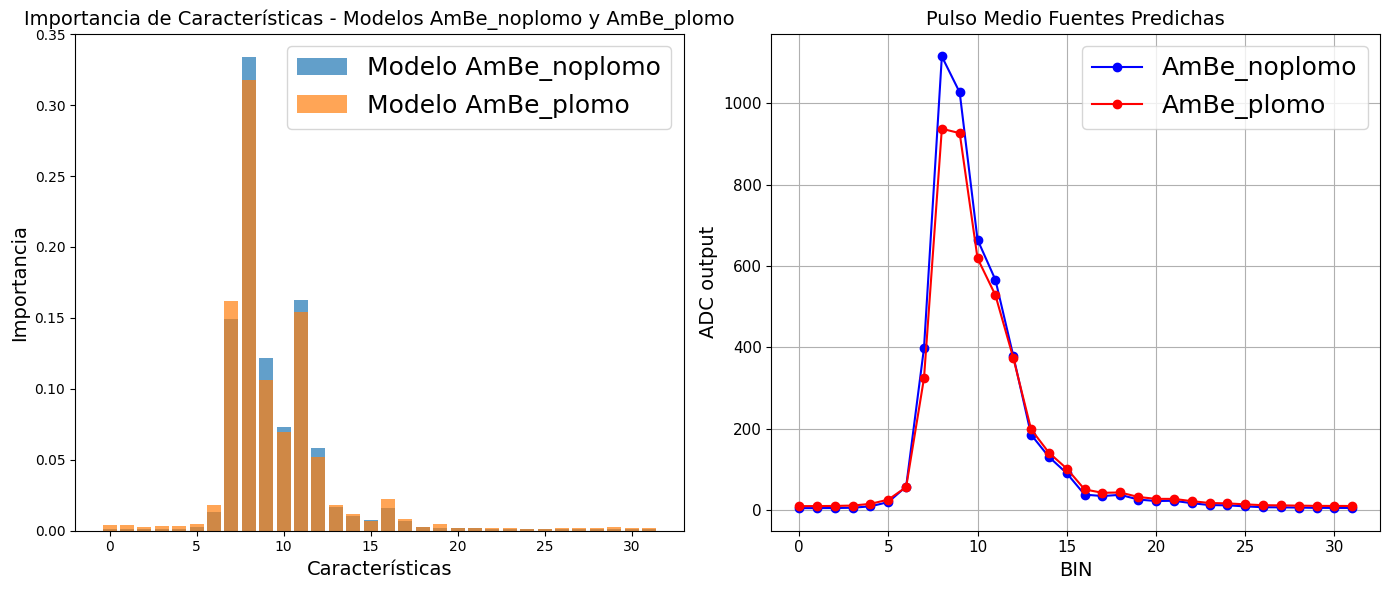

In [25]:
bins = range(32)  # Ejemplo de bins (ajusta según tus datos)

# Crear figura y ejes para los subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Gráfico de barras para importancias de características
features = range(len(importances_noplomo)) 
axs[0].bar(features, importances_noplomo, alpha=0.7, label='Modelo AmBe_noplomo')
axs[0].bar(features, importances_plomo, alpha=0.7, label='Modelo AmBe_plomo')
axs[0].set_xlabel('Características', fontsize=14)
axs[0].set_ylabel('Importancia', fontsize=14)
axs[0].set_title('Importancia de Características - Modelos AmBe_noplomo y AmBe_plomo', fontsize=14)
axs[0].legend(fontsize=18)

# Subplot 2: Gráfico de líneas para pulso medio de fuentes
axs[1].plot(bins, pulso_medio_fuente_predicha_AmBe_noplomo, marker='o', linestyle='-', color='b', label='AmBe_noplomo')
axs[1].plot(bins, pulso_medio_fuente_predicha_AmBe_plomo, marker='o', linestyle='-', color='r', label='AmBe_plomo')
axs[1].set_xlabel('BIN', fontsize=14)
axs[1].set_ylabel('ADC output', fontsize=14)
axs[1].set_title('Pulso Medio Fuentes Predichas', fontsize=14)
axs[1].grid(True)
axs[1].legend(fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=11)

# Ajustar diseño y mostrar la figura
plt.tight_layout()
plt.show()

#### Vamos a entrenear ahora un modelo que solamente le voy a pasar neutrones y gammas

Guardemos nuestros neutrones y gammas predichos sin fondo

In [70]:
import os

output_dir = 'AmBe_filtered'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.savetxt(os.path.join(output_dir, "plomo.csv"), np.array(fuente_predicha_AmBe_plomo), delimiter=',', fmt='%d')
np.savetxt(os.path.join(output_dir, "noplomo.csv"), np.array(fuente_predicha_AmBe_noplomo), delimiter=',', fmt='%d')

print(f"Datos guardados en {output_dir}")


Datos guardados en AmBe_filtered


#### Usemos nuestro modelo supervisado para predecir en los pulsos mixtos de noplomo.csv

In [82]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

Carguemos nuestros modelos entrenados

In [83]:
clf_AmBe_plomo = joblib.load('model/modelo_AmBe_plomo.pkl')
clf_AmBe_noplomo = joblib.load('model/modelo_AmBe_noplomo.pkl')

Usamos los modelos guardados anteriormente para predecir pulsos en noplomo_pulsos.csv

In [84]:
noplomo_file = 'AmBe_filtered/noplomo.csv'
noplomo_pulsos = np.loadtxt(noplomo_file, delimiter=',')

predictions_AmBe_plomo = clf_AmBe_plomo.predict(noplomo_pulsos)
predictions_AmBe_noplomo = clf_AmBe_noplomo.predict(noplomo_pulsos)

# Identificar los pulsos de neutrones y gamma
# Neutrones serían aquellos que el modelo AmBe_plomo predice como fuente
neutrones_predicha = noplomo_pulsos[predictions_AmBe_plomo == 1]
# Los gammas serian los que no son fuente de AmBe_plomo pero si son fuente de AmBe_noplomo
gamma_predicha = noplomo_pulsos[(predictions_AmBe_plomo == 0) & (predictions_AmBe_noplomo == 1)]

K-Means

In [85]:
# Se estandarizan los datos para clustering, es decir, se normalizan para tener media 0 y desviación estándar 1
scaler = StandardScaler()
gamma_neutrones_scaled = scaler.fit_transform(noplomo_pulsos)

# Se aplica el algoritmo K-means para agrupar los datos en 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(gamma_neutrones_scaled)

# Se utiliza PCA para reducir la dimensionalidad de los datos a 2 componentes principales para visualización
pca = PCA(n_components=2)
gamma_neutrones_pca = pca.fit_transform(gamma_neutrones_scaled)

In [86]:
# Calcular métricas de clustering
silhouette_avg = silhouette_score(gamma_neutrones_scaled, clusters)
davies_bouldin = davies_bouldin_score(gamma_neutrones_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(gamma_neutrones_scaled, clusters)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.8291226956135664
Davies-Bouldin Index: 0.6981264728040425
Calinski-Harabasz Index: 153602.88878910872


-   Silhouette Score: mide cómo de similares son los puntos a su propio cluster en comparación con otros clusters. Un valor más alto indica clusters más definidos (0.829 indica que los clusters están bien definidos)
-   Davies-Bouldin Index: mide la media de las razones de la dispersión intra-cluster y la distancia entre clusters. Valores más bajos indican mejores clusters (0.698 sugiere que hay una buena separación entre los clusters)
-   Calinski-Harabasz Index: mide la relación entre la dispersión dentro de los clusters y la dispersión entre los clusters. Valores más altos indican una mejor separación entre clusters (153602 es un valor muy alto, lo que sugiere una buena cohesión dentro de los clusters y una buena separación entre ellos)

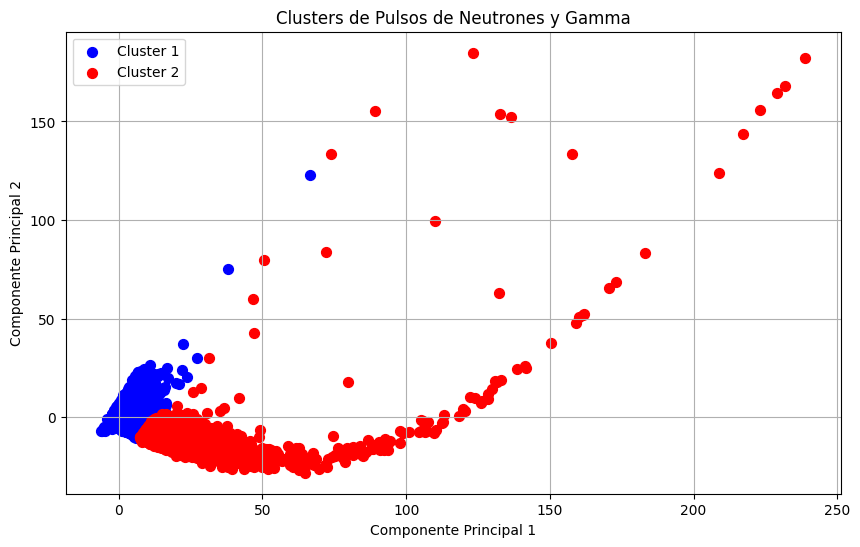

In [87]:
# Visualizar los clusters en 2D
plt.figure(figsize=(10, 6))
plt.scatter(gamma_neutrones_pca[clusters == 0, 0], gamma_neutrones_pca[clusters == 0, 1], 
            s=50, c='blue', label='Cluster 1')
plt.scatter(gamma_neutrones_pca[clusters == 1, 0], gamma_neutrones_pca[clusters == 1, 1], 
            s=50, c='red', label='Cluster 2')
plt.title('Clusters de Pulsos de Neutrones y Gamma')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

La imagen muestra la distribución de los pulsos en el espacio reducido a 2D mediante PCA, coloreados según los clusters asignados por K-means. Observamos dos grupos distintos:

-   Cluster 1 (Azul):
        Representa una agrupación de pulsos que comparten características similares según las primeras dos componentes principales de PCA.

-   Cluster 2 (Rojo):
        Representa una agrupación diferente de pulsos con características distintas.

-   Agrupamiento: La imagen muestra que los datos se han agrupado en dos clusters distintos. Sin embargo, hay una notable superposición en algunas áreas, especialmente cerca del origen (0,0), lo que podría indicar la presencia de puntos que no están claramente definidos en un cluster específico.

-   Distribución de Datos: La distribución de los puntos sugiere que algunos pulsos tienen características más homogéneas (Cluster 1) mientras que otros son más heterogéneos (Cluster 2).

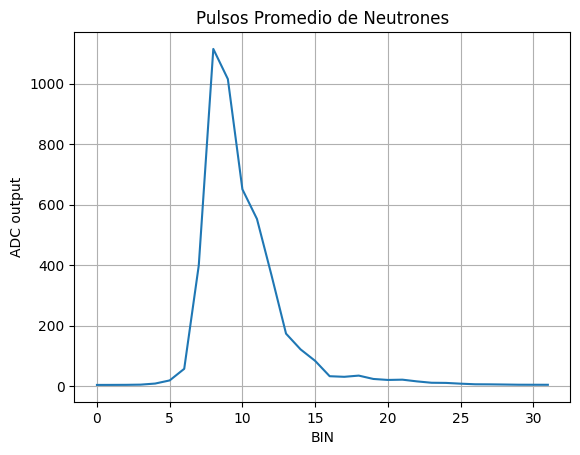

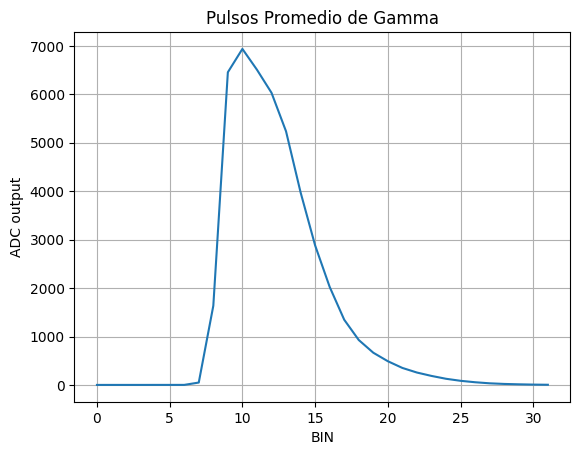

In [88]:
# Visualizar los resultados promedio
def plot_pulse_average(pulso_medio, title):
    plt.plot(pulso_medio)
    plt.title(title)
    plt.xlabel('BIN')
    plt.ylabel('ADC output')
    plt.grid(True)
    plt.show()

plot_pulse_average(np.mean(neutrones_predicha, axis=0), "Pulsos Promedio de Neutrones")
plot_pulse_average(np.mean(gamma_predicha, axis=0), "Pulsos Promedio de Gamma")

In [89]:
neutrones_predicha.shape, gamma_predicha.shape

((403225, 32), (907, 32))

#### Esto no está diferenciando bien gammas de neutrones, solamente 907 gammas en los datos sin plomo? Ciertamente son muy parecidos los 2 modelos AmBe_plomo y AmBe_noplomo

## Abramos la caja de pandora

#### CNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical

# Cargar datos
def cargar_datos(neutrones_file, gamma_neutrones_file):
    """
    Load data from two files and return the combined data and labels.

    Parameters:
    neutrones_file (str): The file path for the neutrones data.
    gamma_neutrones_file (str): The file path for the gamma neutrones data.

    Returns:
    tuple: A tuple containing the combined data and labels.
        The data is a numpy array with shape (n_samples, n_features),
        where n_samples is the total number of samples and n_features is the number of features.
        The labels is a numpy array with shape (n_samples,), where each element represents the label for the corresponding sample.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_neutrones_pulsos = np.loadtxt(gamma_neutrones_file, delimiter=',')
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_neutrones_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_neutrones_pulsos))
    return data, labels

plomo_file = 'AmBe_filtered/plomo.csv'
noplomo_file = 'AmBe_filtered/noplomo.csv'
data, labels = cargar_datos(plomo_file, noplomo_file)

2024-06-23 11:48:03.718713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 11:48:05.861932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Normalización de los datos
scaler = StandardScaler()
data = scaler.fit_transform(data)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Balanceo de clases con SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

# Redimensionar datos para entrada a la CNN
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], X_train_balanced.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Se redimensionan los datos para que puedan ser aceptados por la red neuronal convolucional 
y_train_balanced = to_categorical(y_train_balanced, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [3]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Se define la arquitectura de la red neuronal convolucional (CNN) utilizando capas
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_balanced.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Configurar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Se entrena el modelo utilizando los datos balanceados de entrenamiento y se valida con los datos de prueba.
history = model.fit(X_train_balanced, y_train_balanced, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

/home/said/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-23 11:48:36.086781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 11:48:37.119616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - accuracy: 0.8011 - loss: 0.4111 - val_accuracy: 0.8712 - val_loss: 0.3495
Epoch 2/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.8309 - loss: 0.3561 - val_accuracy: 0.8692 - val_loss: 0.3399
Epoch 3/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8359 - loss: 0.3437 - val_accuracy: 0.8776 - val_loss: 0.3124
Epoch 4/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8394 - loss: 0.3358 - val_accuracy: 0.8718 - val_loss: 0.3219
Epoch 5/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8425 - loss: 0.3310 - val_accuracy: 0.8693 - val_loss: 0.3237
Epoch 6/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.8424 - loss: 0.3299 - val_accuracy: 0.8658 - val_loss: 0.3329
Epoch 7/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.8456 - loss: 0.3269 - val_accuracy: 0.8734 - val_loss: 0.3178
Epoch 8/30
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 

In [4]:
# Evaluación del modelo
score = model.evaluate(X_test, y_test, verbose=0)
print("CNN Accuracy:", score[1])

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

CNN Accuracy: 0.8823570609092712
5774/5774 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Confusion Matrix:
 [[116840   4590]
 [ 17143  46164]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91    121430
           1       0.91      0.73      0.81     63307

    accuracy                           0.88    184737
   macro avg       0.89      0.85      0.86    184737
weighted avg       0.88      0.88      0.88    184737



6615/6615 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
12630/12630 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


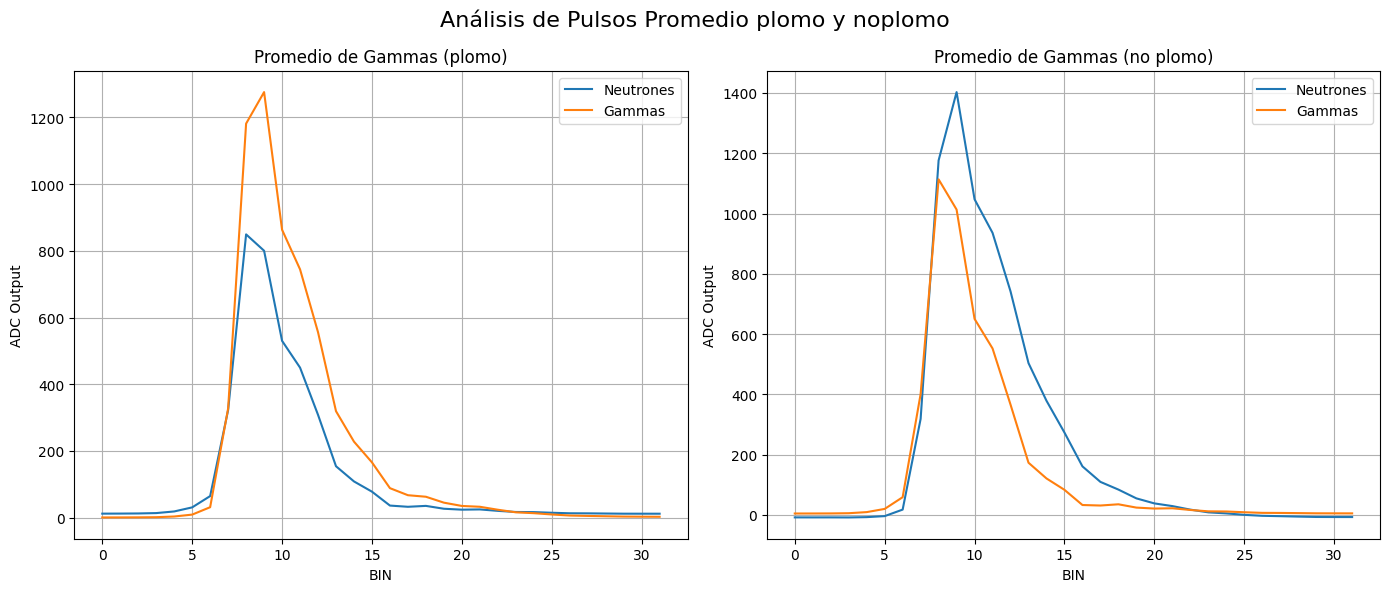

Cantidad de neutrones en plomo.csv (155249, 32)
Cantidad de gammas en plomo.csv (56409, 32)
Carga de neutrones en plomo.csv : 634575429.0
Carga de gammas en plomo.csv: 345566682.0


Cantidad de neutrones en noplomo.csv (14472, 32)
Cantidad de gammas en noplomo.csv (389660, 32)
Carga de neutrones en noplomo.csv : 104524845.0
Carga de gammas en noplomo.csv: 1881391419.0


In [5]:
# Función para cargar y predecir los datos
import matplotlib.pyplot as plt
def load_and_predict(file, model, scaler):
    """
    Load data from a file, preprocess it using a scaler, and predict the class labels using a model.

    Args:
        file (str): The path to the file containing the data.
        model: The trained model used for prediction.
        scaler: The scaler used to preprocess the data.

    Returns:
        tuple: A tuple containing two arrays - neutron_pulses and gamma_pulses.
               neutron_pulses: An array of neutron pulses predicted by the model.
               gamma_pulses: An array of gamma pulses predicted by the model.
    """
    data = np.loadtxt(file, delimiter=',')
    # Escalar los datos utilizando el scaler entrenado
    data_scaled = scaler.transform(data)
    # Cambiar la forma de los datos para que sean aceptados por la CNN
    data_scaled = data_scaled.reshape(data_scaled.shape[0], data_scaled.shape[1], 1)
    # Predecir etiquetas utilizando el modelo
    y_pred_all = model.predict(data_scaled)
    # Obtener la clase con la probabilidad más alta para cada muestra.
    y_pred_all_classes = np.argmax(y_pred_all, axis=1)
    # Desescalar los datos para obtener los valores originales
    data_descaled = scaler.inverse_transform(data_scaled.reshape(data_scaled.shape[0], data_scaled.shape[1]))
    # Separar los pulsos predichos en neutrones y gammas según las clases predichas
    neutron_pulses = data_descaled[y_pred_all_classes == 1]
    gamma_pulses = data_descaled[y_pred_all_classes == 0]
    return neutron_pulses, gamma_pulses

def plot_pulse_average(ax, pulse_data, title, label):
    """
    Plots the average pulse data on the given axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes on which to plot the data.
    - pulse_data (numpy.ndarray): The pulse data to plot.
    - title (str): The title of the plot.
    - label (str): The label for the plotted line.

    Returns:
    None
    """
    ax.plot(np.mean(pulse_data, axis=0), label=label)
    ax.set_title(title)
    ax.set_xlabel('BIN')
    ax.set_ylabel('ADC Output')
    ax.grid(True)
    ax.legend()

# Cargar y predecir datos para plomo.csv
neutron_pulses_plomo, gamma_pulses_plomo = load_and_predict(plomo_file, model, scaler)

# Cargar y predecir datos para noplomo.csv
neutron_pulses_noplomo, gamma_pulses_noplomo = load_and_predict(noplomo_file, model, scaler)

# Crear subplots (2 subplots, 1 row)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot neutrones y gammas para plomo.csv
plot_pulse_average(ax1, neutron_pulses_plomo, 'Promedio de Neutrones (plomo)', 'Neutrones')
plot_pulse_average(ax1, gamma_pulses_plomo, 'Promedio de Gammas (plomo)', 'Gammas')

# Plot neutrones y gammas para noplomo.csv
plot_pulse_average(ax2, neutron_pulses_noplomo, 'Promedio de Neutrones (no plomo)', 'Neutrones')
plot_pulse_average(ax2, gamma_pulses_noplomo, 'Promedio de Gammas (no plomo)', 'Gammas')

fig.suptitle('Análisis de Pulsos Promedio plomo y noplomo', fontsize=16)
plt.tight_layout()
plt.show()

print(f'Cantidad de neutrones en plomo.csv {neutron_pulses_plomo.shape}')
print(f'Cantidad de gammas en plomo.csv {gamma_pulses_plomo.shape}')
print(f'Carga de neutrones en plomo.csv : {neutron_pulses_plomo.sum()}')
print(f'Carga de gammas en plomo.csv: {gamma_pulses_plomo.sum()}')
print('\n')
print(f'Cantidad de neutrones en noplomo.csv {neutron_pulses_noplomo.shape}')
print(f'Cantidad de gammas en noplomo.csv {gamma_pulses_noplomo.shape}')
print(f'Carga de neutrones en noplomo.csv : {neutron_pulses_noplomo.sum()}')
print(f'Carga de gammas en noplomo.csv: {gamma_pulses_noplomo.sum()}')

#### Makes no sense

#### Ingeniería de características

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Cargar datos
def cargar_datos(neutrones_file, gamma_neutrones_file):
    """
    Load data from two files and return the combined data and labels.

    Parameters:
    neutrones_file (str): The file path for the neutrones data.
    gamma_neutrones_file (str): The file path for the gamma neutrones data.

    Returns:
    tuple: A tuple containing the combined data and labels.
        The data is a numpy array with shape (n_samples, n_features),
        where n_samples is the total number of samples and n_features is the number of features.
        The labels is a numpy array with shape (n_samples,), where each element represents the label for a sample.
        The label is 1 for neutrones data and 0 for gamma neutrones data.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_neutrones_pulsos = np.loadtxt(gamma_neutrones_file, delimiter=',')
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_neutrones_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_neutrones_pulsos))
    return data, labels

plomo_file = 'AmBe_filtered/plomo.csv'
noplomo_file = 'AmBe_filtered/noplomo.csv'
data, labels = cargar_datos(plomo_file, noplomo_file)

# Normalización de los datos
scaler = StandardScaler()
data = scaler.fit_transform(data)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Balanceo de clases con SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [5]:
def extraer_caracteristicas(pulsos):
    """
    Extracts features from a list of pulses.

    Parameters:
    pulsos (list): A list of pulses.

    Returns:
    numpy.ndarray: An array of extracted features.

    """
    features = []
    for pulso in pulsos:
        media = np.mean(pulso)
        std_dev = np.std(pulso)
        prop = np.sum(pulso) / np.max(pulso)
        subida = np.argmax(pulso)
        bajada = 32 - subida
        # Añadir más características según sea necesario
        features.append([media, std_dev, prop, subida, bajada])
    return np.array(features)

X_train_features = extraer_caracteristicas(X_train_balanced)
X_test_features = extraer_caracteristicas(X_test)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Definición del modelo gradient boosting con 100 árboles, una tasa de aprendizaje de 0.1 y una profundidad máxima de 3
gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenamiento del modelo
gbm_clf.fit(X_train_features, y_train_balanced)

# Predicciones
y_pred_gbm = gbm_clf.predict(X_test_features)

# Evaluación del modelo
print("Gradient Boosting Accuracy:", np.mean(y_pred_gbm == y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))
print("Classification Report:\n", classification_report(y_test, y_pred_gbm))

Gradient Boosting Accuracy: 0.7323059268040512
Confusion Matrix:
 [[98853 22577]
 [26876 36431]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80    121430
           1       0.62      0.58      0.60     63307

    accuracy                           0.73    184737
   macro avg       0.70      0.69      0.70    184737
weighted avg       0.73      0.73      0.73    184737



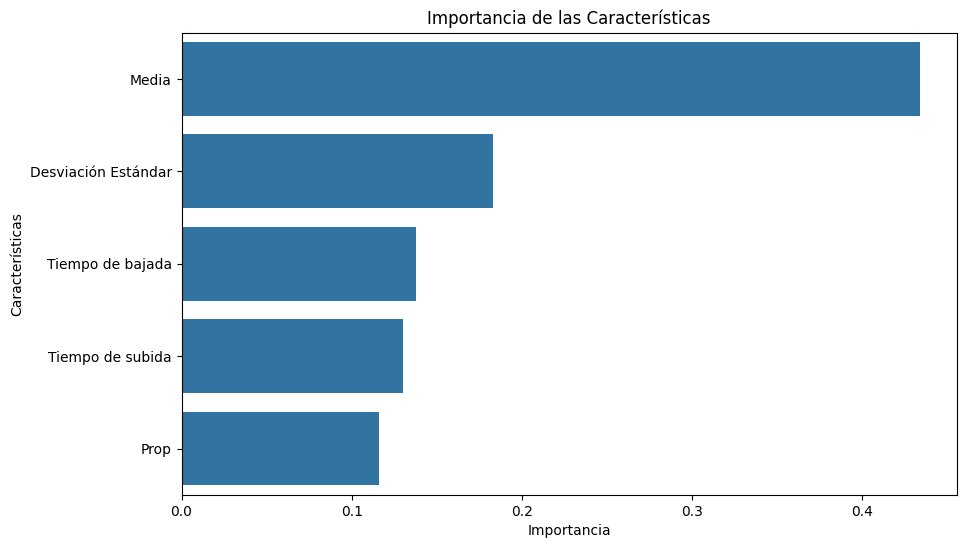

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Importancia de las características
feature_importances = gbm_clf.feature_importances_
features = ['Media', 'Desviación Estándar', 'Prop', 'Tiempo de subida', 'Tiempo de bajada']

# Crear un DataFrame para facilitar la visualización
importancia_df = pd.DataFrame({'Características': features, 'Importancia': feature_importances})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Gráfico de barras de la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Características', data=importancia_df)
plt.title('Importancia de las Características')
plt.show()

Esto me parece prueba y error honestamente, los pulsos son muy parecidos, me gustaría abordar otros modelos antes de buscar las mejores características para mi problema

#### Más clasificadores

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Cargar datos
def cargar_datos(neutrones_file, gamma_neutrones_file):
    """
    Load data from two files and return the combined data and labels.

    Parameters:
    neutrones_file (str): The file path for the neutrones data.
    gamma_neutrones_file (str): The file path for the gamma_neutrones data.

    Returns:
    tuple: A tuple containing the combined data and labels.
        The data is a numpy array with shape (n_samples, n_features),
        where n_samples is the total number of samples and n_features is the number of features.
        The labels is a numpy array with shape (n_samples,), where each element represents the label for a sample.
        The label is 1 for neutrones data and 0 for gamma_neutrones data.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_neutrones_pulsos = np.loadtxt(gamma_neutrones_file, delimiter=',')
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_neutrones_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_neutrones_pulsos))
    return data, labels

plomo_file = 'AmBe_filtered/plomo.csv'
noplomo_file = 'AmBe_filtered/noplomo.csv'
data, labels = cargar_datos(plomo_file, noplomo_file)

# Normalización de los datos
scaler = StandardScaler()
data = scaler.fit_transform(data)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Balanceo de clases con SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Definición y entrenamiento del modelo de clasificación k-Nearest Neighbors (k-NN) 5 vecinos
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_balanced, y_train_balanced)
y_pred_knn = knn_clf.predict(X_test)

# Evaluación del modelo k-NN 
print("k-NN Accuracy:", np.mean(y_pred_knn == y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

k-NN Accuracy: 0.7727796813848877
Confusion Matrix:
 [[94218 27212]
 [14764 48543]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82    121430
           1       0.64      0.77      0.70     63307

    accuracy                           0.77    184737
   macro avg       0.75      0.77      0.76    184737
weighted avg       0.79      0.77      0.78    184737



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_predict(file, model, scaler):
    """
    Load data from a file, preprocess it using a scaler, and make predictions using a model.

    Parameters:
    file (str): The path to the file containing the data.
    model: The machine learning model used for prediction.
    scaler: The scaler used to preprocess the data.

    Returns:
    neutron_pulses: An array of neutron pulses predicted by the model.
    gamma_pulses: An array of gamma pulses predicted by the model.
    """
    data = np.loadtxt(file, delimiter=',')
    data_scaled = scaler.fit_transform(data)
    y_pred_all = model.predict(data_scaled)
    y_pred_all_classes = (y_pred_all > 0.5).astype(int)
    data_descaled = scaler.inverse_transform(data_scaled)
    neutron_pulses = data_descaled[y_pred_all_classes == 1]
    gamma_pulses = data_descaled[y_pred_all_classes == 0]
    return neutron_pulses, gamma_pulses

def plot_pulse_average(ax, pulse_data, title, label):
    """
    Plots the average pulse data on the given axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes on which to plot the data.
    - pulse_data (numpy.ndarray): The pulse data to plot.
    - title (str): The title of the plot.
    - label (str): The label for the plotted data.

    Returns:
    None
    """
    ax.plot(np.mean(pulse_data, axis=0), label=label)
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('BIN', fontsize = 14)
    ax.set_ylabel('ADC Output', fontsize = 14)
    ax.grid(True)
    ax.legend(fontsize = 18)

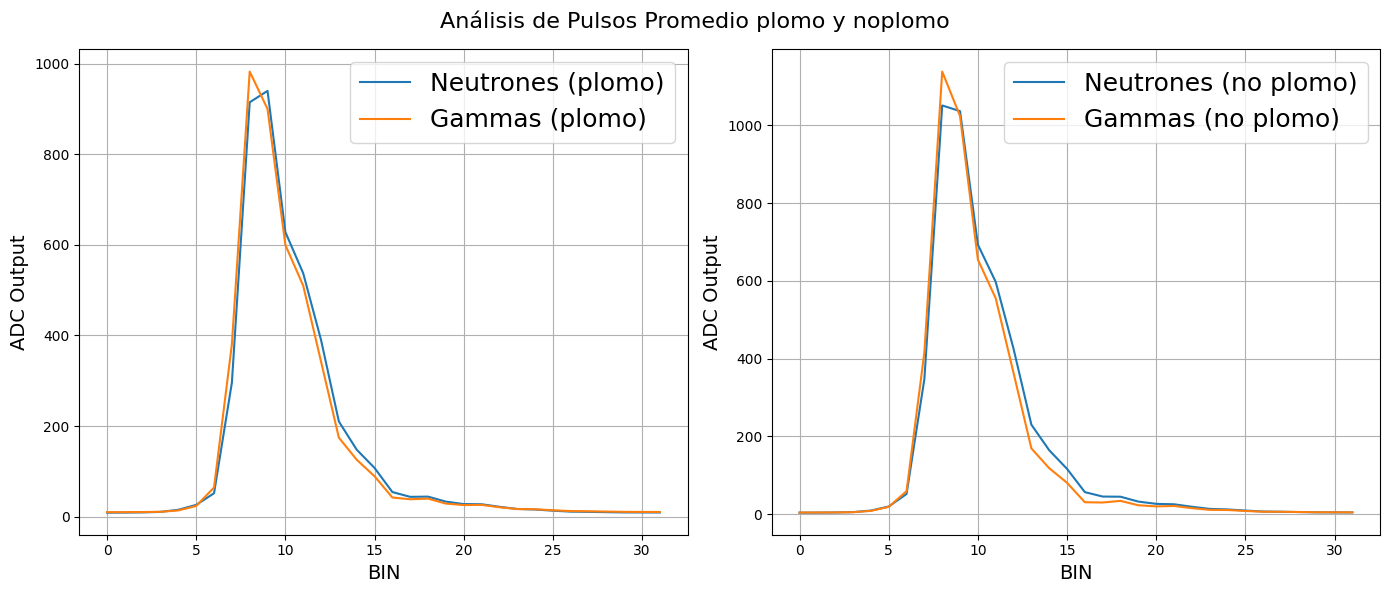

Cantidad de neutrones en plomo.csv (141212, 32)
Cantidad de gammas en plomo.csv (70446, 32)
Carga de neutrones en plomo.csv : 657525128.0
Carga de gammas en plomo.csv: 322616983.0


Cantidad de neutrones en noplomo.csv (104725, 32)
Cantidad de gammas en noplomo.csv (299407, 32)
Carga de neutrones en noplomo.csv : 531473652.0
Carga de gammas en noplomo.csv: 1454442612.0


In [6]:
scaler = StandardScaler()
best_model = knn_clf  # Usar el mejor modelo obtenido

# Load and predict data for plomo.csv
neutron_pulses_plomo, gamma_pulses_plomo = load_and_predict(plomo_file, best_model, scaler)

# Load and predict data for noplomo.csv
neutron_pulses_noplomo, gamma_pulses_noplomo = load_and_predict(noplomo_file, best_model, scaler)

# Create subplots (2 subplots, 1 row)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot neutrones y gammas para plomo.csv
plot_pulse_average(ax1, neutron_pulses_plomo, '', 'Neutrones (plomo)')
plot_pulse_average(ax1, gamma_pulses_plomo, '', 'Gammas (plomo)')

# Plot neutrones y gammas para noplomo.csv
plot_pulse_average(ax2, neutron_pulses_noplomo, '', 'Neutrones (no plomo)')
plot_pulse_average(ax2, gamma_pulses_noplomo, '', 'Gammas (no plomo)')

fig.suptitle('Análisis de Pulsos Promedio plomo y noplomo', fontsize=16)

plt.tight_layout()
plt.show()

print(f'Cantidad de neutrones en plomo.csv {neutron_pulses_plomo.shape}')
print(f'Cantidad de gammas en plomo.csv {gamma_pulses_plomo.shape}')
print(f'Carga de neutrones en plomo.csv : {neutron_pulses_plomo.sum()}')
print(f'Carga de gammas en plomo.csv: {gamma_pulses_plomo.sum()}')
print('\n')
print(f'Cantidad de neutrones en noplomo.csv {neutron_pulses_noplomo.shape}')
print(f'Cantidad de gammas en noplomo.csv {gamma_pulses_noplomo.shape}')
print(f'Carga de neutrones en noplomo.csv : {neutron_pulses_noplomo.sum()}')
print(f'Carga de gammas en noplomo.csv: {gamma_pulses_noplomo.sum()}')

#### Mucho mejor que todo lo obtenido hasta ahora, la cantidad de neutrones en ambos archivos es más cercana, lo que no me gusta es que los pulsos gammas sean iguales en ambos espectros y que los neutrones tengan alturas distintas

#### Clasificador basado en stacking

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def cargar_datos(neutrones_file, gamma_neutrones_file):
    """
    Carga los datos de neutrones y gamma desde los archivos proporcionados y crea las etiquetas correspondientes.

    Args:
        neutrones_file (str): Ruta del archivo que contiene los datos de neutrones.
        gamma_neutrones_file (str): Ruta del archivo que contiene los datos de gamma y neutrones.

    Returns:
        tuple: Una tupla que contiene los datos combinados y las etiquetas correspondientes.
            - data (ndarray): Un array numpy que contiene los datos combinados de neutrones y gamma.
            - labels (ndarray): Un array numpy que contiene las etiquetas correspondientes a los datos.
                1 representa neutrones y 0 representa gamma en gamma_neutrones_pulsos.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_neutrones_pulsos = np.loadtxt(gamma_neutrones_file, delimiter=',')
    
    # Etiquetas: 1 para neutrones y 0 para gamma en gamma_neutrones_pulsos
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_neutrones_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_neutrones_pulsos))
    return data, labels

plomo_file = 'AmBe_filtered/plomo.csv'
noplomo_file = 'AmBe_filtered/noplomo.csv'
plomo_pulsos = np.loadtxt(plomo_file, delimiter=',')
noplomo_pulsos = np.loadtxt(noplomo_file, delimiter=',')

data, labels = cargar_datos(plomo_file, noplomo_file)

Preprocesamiento y Balanceo de Clases

In [ ]:
# Normalización de los datos
scaler = StandardScaler()
data = scaler.fit_transform(data)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Balanceo de clases con SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

Entrenamiento del Modelo de Red Neuronal

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Se usa binary_crossentropy como función de pérdida y adam como optimizador, lo que es común en problemas de clasificación binaria
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/home/said/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-19 13:53:56.181077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 13:53:56.260976: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.7889 - loss: 0.4246 - val_accuracy: 0.8624 - val_loss: 0.3178
Epoch 2/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.8500 - loss: 0.3127 - val_accuracy: 0.8694 - val_loss: 0.2986
Epoch 3/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.8528 - loss: 0.3060 - val_accuracy: 0.8760 - val_loss: 0.2920
Epoch 4/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8551 - loss: 0.3024 - val_accuracy: 0.8802 - val_loss: 0.2853
Epoch 5/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8559 - loss: 0.3005 - val_accuracy: 0.8772 - val_loss: 0.2892
Epoch 6/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8571 - loss: 0.2981 - val_accuracy: 0.8710 - val_loss: 0.2973
Epoch 7/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.8589 - loss: 0.2963 - val_accuracy: 0.8753 - val_loss: 0.2910
Epoch 8/10
17669/17669 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 

Evaluación del Modelo

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Red Neuronal Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

5774/5774 ━━━━━━━━━━━━━━━━━━━━ 5s 792us/step
Red Neuronal Accuracy: 0.8712060929862453
Confusion Matrix:
 [[109852  11578]
 [ 12215  51092]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90    121430
           1       0.82      0.81      0.81     63307

    accuracy                           0.87    184737
   macro avg       0.86      0.86      0.86    184737
weighted avg       0.87      0.87      0.87    184737



Accuracy: 87.12%

Matriz de Confusión y Informe de Clasificación:

-   La precisión, recall y f1-score indican un buen desempeño general, aunque con algunas áreas de mejora en la clasificación de la clase minoritaria (neutrones).

Construcción y Entrenamiento de un Modelo de Stacking Classifier

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500))
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(X_train_balanced, y_train_balanced)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('mlp',
                                MLPClassifier(hidden_layer_sizes=(64, 32),
                                              max_iter=500))],
                   final_estimator=LogisticRegression())

Se combinan múltiples clasificadores (RandomForest y MLPClassifier) y se usa un clasificador final (LogisticRegression) para mejorar el rendimiento general

Evaluación del Modelo

In [ ]:
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))

Stacking Classifier Accuracy: 0.8867092136388487
Confusion Matrix:
 [[115981   5449]
 [ 15480  47827]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92    121430
           1       0.90      0.76      0.82     63307

    accuracy                           0.89    184737
   macro avg       0.89      0.86      0.87    184737
weighted avg       0.89      0.89      0.88    184737



Accuracy: 88.67%

Matriz de Confusión y Informe de Clasificación:

-   El desempeño es comparable al de la red neuronal, mostrando que la combinación de múltiples clasificadores también es efectiva.

#### Probando el modelo

En esta sección, cargamos los datos de los archivos proporcionados en plomo y noplomo y predecimos los pulsos en cada caso utilizando el mejor modelo (StackingClassifier). Luego, visualizamos los pulsos promedio para neutrones y gammas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_predict(file, model, scaler):
    """
    Load data from a file, preprocess it using a scaler, and make predictions using a model.

    Parameters:
    file (str): The path to the file containing the data.
    model: The machine learning model used for prediction.
    scaler: The scaler used to preprocess the data.

    Returns:
    neutron_pulses: An array of neutron pulses predicted by the model.
    gamma_pulses: An array of gamma pulses predicted by the model.
    """
    data = np.loadtxt(file, delimiter=',')
    data_scaled = scaler.fit_transform(data)
    y_pred_all = model.predict(data_scaled)
    y_pred_all_classes = (y_pred_all > 0.5).astype(int)
    data_descaled = scaler.inverse_transform(data_scaled)
    neutron_pulses = data_descaled[y_pred_all_classes == 1]
    gamma_pulses = data_descaled[y_pred_all_classes == 0]
    return neutron_pulses, gamma_pulses

def plot_pulse_average(ax, pulse_data, title, label):
    """
    Plots the average pulse data on the given axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes on which to plot the data.
    - pulse_data (numpy.ndarray): The pulse data to plot.
    - title (str): The title of the plot.
    - label (str): The label for the plotted data.

    Returns:
    None
    """
    ax.plot(np.mean(pulse_data, axis=0), label=label)
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('BIN', fontsize = 14)
    ax.set_ylabel('ADC Output', fontsize = 14)
    ax.grid(True)
    ax.legend(fontsize = 18)

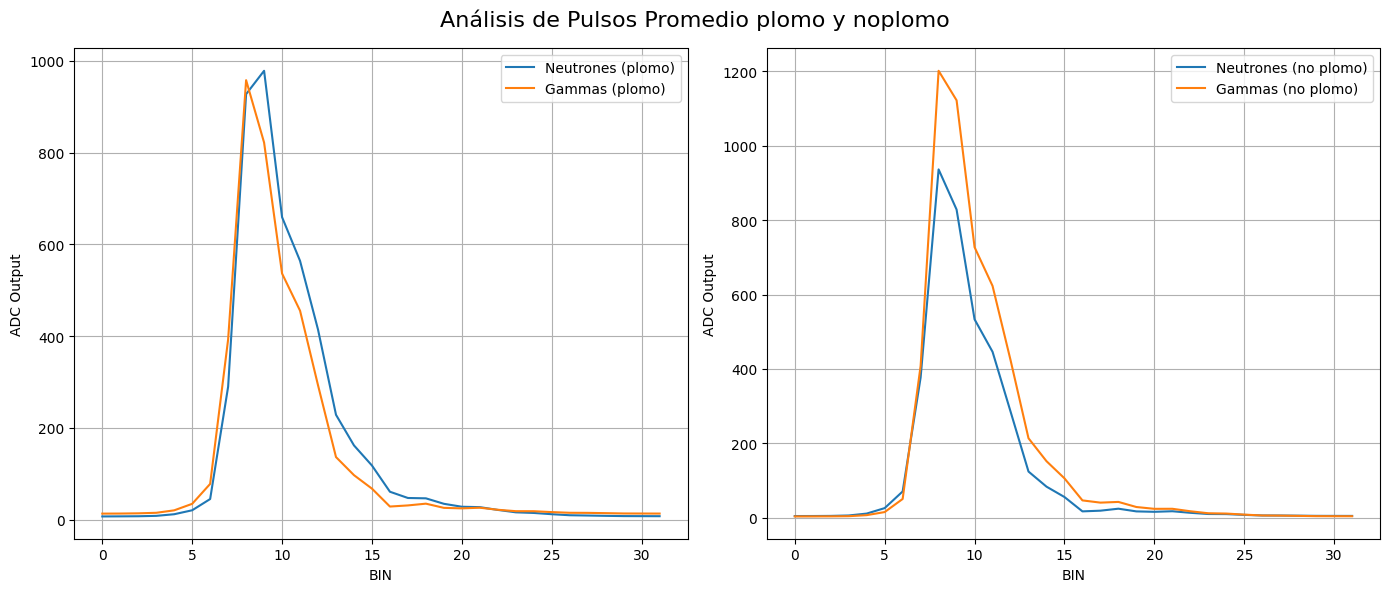

Cantidad de neutrones en plomo.csv (141745, 32)
Cantidad de gammas en plomo.csv (69913, 32)
Carga de neutrones en plomo.csv : 681234930.0
Carga de gammas en plomo.csv: 298907181.0


Cantidad de neutrones en noplomo.csv (130463, 32)
Cantidad de gammas en noplomo.csv (273669, 32)
Carga de neutrones en noplomo.csv : 520309325.0
Carga de gammas en noplomo.csv: 1465606939.0


In [ ]:
scaler = StandardScaler()
best_model = stacking_clf  # Usar el mejor modelo obtenido

# Load and predict data for plomo.csv
neutron_pulses_plomo, gamma_pulses_plomo = load_and_predict(plomo_file, best_model, scaler)

# Load and predict data for noplomo.csv
neutron_pulses_noplomo, gamma_pulses_noplomo = load_and_predict(noplomo_file, best_model, scaler)

# Create subplots (2 subplots, 1 row)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot neutrones y gammas para plomo.csv
plot_pulse_average(ax1, neutron_pulses_plomo, '', 'Neutrones (plomo)')
plot_pulse_average(ax1, gamma_pulses_plomo, '', 'Gammas (plomo)')

# Plot neutrones y gammas para noplomo.csv
plot_pulse_average(ax2, neutron_pulses_noplomo, '', 'Neutrones (no plomo)')
plot_pulse_average(ax2, gamma_pulses_noplomo, '', 'Gammas (no plomo)')

fig.suptitle('Análisis de Pulsos Promedio plomo y noplomo', fontsize=16)

plt.tight_layout()
plt.show()

print(f'Cantidad de neutrones en plomo.csv {neutron_pulses_plomo.shape}')
print(f'Cantidad de gammas en plomo.csv {gamma_pulses_plomo.shape}')
print(f'Carga de neutrones en plomo.csv : {neutron_pulses_plomo.sum()}')
print(f'Carga de gammas en plomo.csv: {gamma_pulses_plomo.sum()}')
print('\n')
print(f'Cantidad de neutrones en noplomo.csv {neutron_pulses_noplomo.shape}')
print(f'Cantidad de gammas en noplomo.csv {gamma_pulses_noplomo.shape}')
print(f'Carga de neutrones en noplomo.csv : {neutron_pulses_noplomo.sum()}')
print(f'Carga de gammas en noplomo.csv: {gamma_pulses_noplomo.sum()}')

-   141,745 de neutrones en plomo y 130,463 en noplomo. Esto tiene sentido físico, puesto que ambas mediciones se diferencian en el uso de blindaje de plomo, el cual no escuda neutrones

-   El pulso medio para los gammas es mayor para noplomo que para plomo, esto también tiene sentido, los gammas de la fuente son mucho más energéticos que los que puedan provocar los neutrones en el proceso de termalización chocando inelásticamente con los átomos del medio y ionizandolos

-   La precisión del Stacking es del 88.7%, lo cual es claramente mejorable

Guardemos nuestro mejor modelo por ahora

In [ ]:
import joblib
import os

file_name = 'simple_neutrones_gamma.pkl'

directory = 'models'

if not os.path.exists(directory):
    os.makedirs(directory)

# Ruta completa del archivo
filepath = os.path.join(directory, file_name)

# Guardar el modelo utilizando joblib
joblib.dump(stacking_clf, filepath)

print(f"Modelo guardado exitosamente en '{filepath}'.")

In [7]:
import joblib
import os

file_name = 'simple_neutrones_gamma.pkl'
directory = 'models'

# Ruta completa del archivo
filepath = os.path.join(directory, file_name)

# Cargar el modelo utilizando joblib
stacking_clf = joblib.load(filepath)

print(f"Modelo cargado exitosamente desde '{filepath}'.")

Modelo cargado exitosamente desde 'models/simple_neutrones_gamma.pkl'.


#### Veamos la curva ROC 

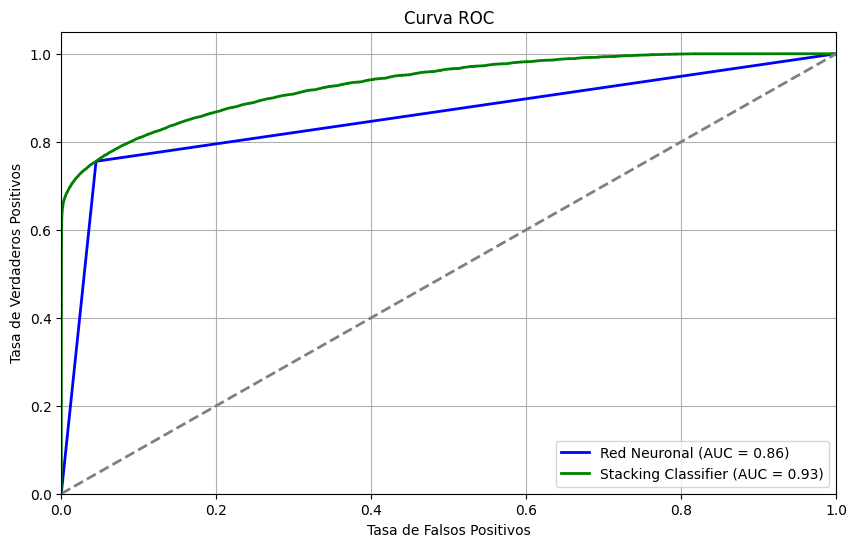

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def cargar_datos(neutrones_file, gamma_neutrones_file):
    """
    Carga los datos de neutrones y gamma desde los archivos proporcionados y crea las etiquetas correspondientes.

    Args:
        neutrones_file (str): Ruta del archivo que contiene los datos de neutrones.
        gamma_neutrones_file (str): Ruta del archivo que contiene los datos de gamma y neutrones.

    Returns:
        tuple: Una tupla que contiene los datos combinados y las etiquetas correspondientes.
            - data (ndarray): Un array numpy que contiene los datos combinados de neutrones y gamma.
            - labels (ndarray): Un array numpy que contiene las etiquetas correspondientes a los datos.
                1 representa neutrones y 0 representa gamma en gamma_neutrones_pulsos.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_neutrones_pulsos = np.loadtxt(gamma_neutrones_file, delimiter=',')
    
    # Etiquetas: 1 para neutrones y 0 para gamma en gamma_neutrones_pulsos
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_neutrones_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_neutrones_pulsos))
    return data, labels

plomo_file = 'AmBe_filtered/plomo.csv'
noplomo_file = 'AmBe_filtered/noplomo.csv'
plomo_pulsos = np.loadtxt(plomo_file, delimiter=',')
noplomo_pulsos = np.loadtxt(noplomo_file, delimiter=',')

data, labels = cargar_datos(plomo_file, noplomo_file)

# Normalización de los datos
scaler = StandardScaler()
data = scaler.fit_transform(data)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

y_pred_proba_nn = stacking_clf.predict(X_test).ravel()
y_pred_classes_nn = (y_pred_proba_nn > 0.5).astype(int)

y_pred_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_stack = (y_pred_proba_stack > 0.5).astype(int)

# Calcular ROC y AUC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)

# Plotear ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label='Red Neuronal (AUC = %0.2f)' % roc_auc_nn)
plt.plot(fpr_stack, tpr_stack, color='green', lw=2, label='Stacking Classifier (AUC = %0.2f)' % roc_auc_stack)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Rendimiento de ambos clasificadores bastante alto. El Stacking Classifier supera a la Red Neuronal en términos de rendimiento, como se evidencia por el AUC más alto (0.93 frente a 0.86) y una curva ROC que está más cerca del eje Y

#### Se intentó hacer un ajuste de hiperparámetros para mejorar el stacking, pero los resultados no están dando del todo bien, y el coste computacional es demasiado alto

In [ ]:
# Ajuste de Hiperparámetros para MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (100,)], # Diferentes configuraciones para las capas ocultas y sus neuronas
    'activation': ['tanh', 'relu'], # Funciones de activación que se probarán
    'solver': ['adam', 'sgd'], # Algoritmos de optimización
    'alpha': [0.0001, 0.001], # Parámetro de regularización
    'learning_rate': ['constant', 'adaptive'], #Tipo de tasa de aprendizaje
}

# cv=5: Usa una validación cruzada de 5 pliegues
# n_jobs=-1: Usa todos los núcleos disponibles para paralelizar el trabajo
# verbose=2: Proporciona una salida detallada del progreso
grid_search_mlp = GridSearchCV(estimator=MLPClassifier(max_iter=500, random_state=42), 
                               param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)

grid_search_mlp.fit(X_train_balanced, y_train_balanced)
print("Mejores parámetros para MLPClassifier: ", grid_search_mlp.best_params_)

Mejora del Modelo:

-   Optimización: Ajusta automáticamente los hiperparámetros para mejorar la precisión y la capacidad de generalización del MLPClassifier.
-   Validación Cruzada: Asegura que los resultados no estén sesgados y que el modelo generalice bien a nuevos datos.

In [ ]:
# Ajuste de Hiperparámetros para LogisticRegression
param_grid_lr = {
    'penalty': ['l2'], # Tipo de penalización
    'C': [0.01, 0.1, 1, 10, 100], # Inverso de la regularización
    'solver': ['lbfgs', 'saga'] #  Algoritmos de optimización
}

# Realizamos una búsqueda en cuadrícula con validación cruzada para encontrar la mejor combinación de hiperparámetros
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42), 
                              param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)

grid_search_lr.fit(X_train_balanced, y_train_balanced)
print("Mejores parámetros para LogisticRegression: ", grid_search_lr.best_params_)

Mejora del Modelo:

-   Optimización: Ajusta automáticamente los hiperparámetros para maximizar la precisión y minimizar el sobreajuste en la regresión logística.
-   Validación Cruzada: Asegura que los resultados no estén sesgados y que el modelo generalice bien a nuevos datos.

In [ ]:
# Ajuste de Hiperparámetros para RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'], #  Número máximo de características consideradas para dividir un nodo ('auto' no es válido, se usa 'sqrt' o 'log2' tengo q sacarlo)
    'max_depth': [4, 6, 8, 10, 12], # Profundidad máxima de los árboles
    'criterion': ['gini', 'entropy'] # Función de evaluación de la calidad de una división
}

#  Realizamos una búsqueda en cuadrícula con validación cruzada para encontrar la mejor combinación de hiperparámetros
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train_balanced, y_train_balanced)
print("Mejores parámetros para RandomForestClassifier: ", grid_search_rf.best_params_)

Mejora del Modelo:

-   Optimización: Ajusta automáticamente los hiperparámetros para mejorar la precisión y la capacidad de generalización del RandomForestClassifier.
-   Validación Cruzada: Asegura que los resultados no estén sesgados y que el modelo generalice bien a nuevos datos.

En el artículo presentado, los autores hacen una comparación de los diferentes modelos de clasificación y encuentran los mejores para este tipo de problemas

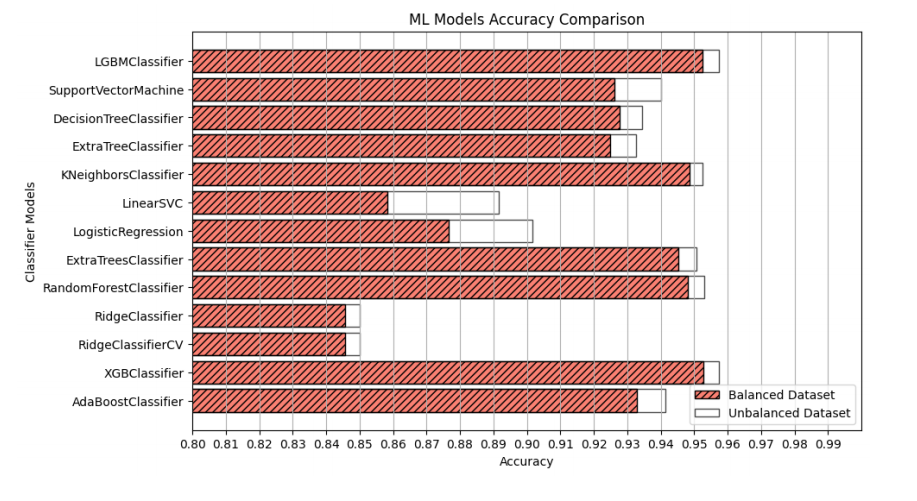

## Conclusiones:

#### El Stacking parece ser el way to go
#### Aún hay mucho por hacer
-   Ajustar bien los hiperparámetros tanto de los modelos base como de la regresión logística (mucho costo computacional)
-   Intentar diversas combinaciones de clasificadores base para el stacking
-   Quizás aumentar la complejidad de la red elegida (costo - beneficio)

#### De manera general estoy bastante satisfecho con los resultados, hay margen de mejora pero el problema no parece ser imposible de resolver, más que a un final me parece más un incentivo a seguir trabajando el problema con más datos de diferentes tipos de fuentes combinados con fondo

## Sugerencias de los profes de ML: